In [29]:
import pandas as pd
import numpy as np
import math
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from io import StringIO

          X          Y
0  0.749080   7.606466
1  1.901429  21.018091
2  1.463988  16.129919
3  1.197317  12.897874
4  0.312037   4.412079


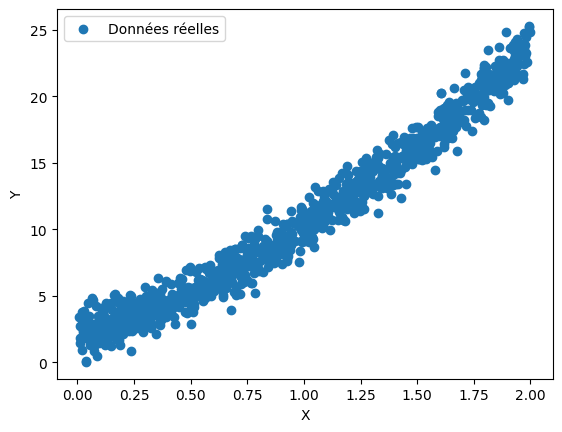

In [30]:
# Fixer la graine aléatoire pour la reproductibilité
np.random.seed(42)

# Générer des données avec 1000 lignes
X = 2 * np.random.rand(1000, 1)
Y = 3 * X**2 + 5 * X + 2 + np.random.randn(1000, 1)

# Créer un DataFrame
df = pd.DataFrame({'X': X.flatten(), 'Y': Y.flatten()})

# Afficher les premières lignes du DataFrame
print(df.head())

# Afficher les données
plt.scatter(X, Y, label='Données réelles')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [31]:
name_feature = 'X'
name_target = 'Y'

In [32]:
# Shuffle the DataFrame
df_shuffled = shuffle(df, random_state=200)

# Split the shuffled DataFrame into train and test
train = df_shuffled.sample(frac=0.8, random_state=200) # type: ignore
test = df_shuffled[~df_shuffled.index.isin(train.index)]

# Reset the indices for both train and test DataFrames
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


In [33]:
def matrix_X(data, name_feature,n):
  X = np.zeros((len(data), n + 1))
  for i in range(n):
      X[:, i] = data[name_feature].values ** (n - i)
  X[:, -1] = 1
  X[:, :-1] = (X[:, :-1] - np.mean(X[:, :-1], axis=0)) / np.std(X[:, :-1], axis=0)
  return X

In [34]:
def matrix_Y(data,name_target,m):
  Y = np.array([data[name_target]])
  Y = Y.reshape(m,1)
  return Y

In [35]:
def matrix_theta(n):
  np.random.seed(142)
  THETA = np.random.randn(n+1,1)
  return THETA

In [36]:
def matrix_F(X,THETA):
  F = X.dot(THETA)
  return F

In [37]:
def calculate_J(X,Y,F,m):
  J = 1/2 * m * np.sum((F - Y)**2)
  return J

In [38]:
def metrics(X,Y,F,m):
  mse = calculate_J(X,Y,F,m)
  rmse = math.sqrt(mse)
  R2 = 1 - np.sum((F - Y)**2) / np.sum((Y - Y.mean())**2)
  dict_metrics = {'MSE':mse,'RMSE':rmse,'R2':R2}
  df_metrics = pd.Series(dict_metrics)
  return df_metrics

In [39]:
def store_the_good_coefficients(THETA, rmse):
    # Charger le DataFrame depuis le fichier CSV s'il existe
    try:
        coefficients_df = pd.read_csv('data/coefficient.csv')
    except FileNotFoundError:
        coefficients_df = pd.DataFrame(columns=['θ', 'rmse à l\'entrainement'])

    # Si le DataFrame est vide ou la nouvelle RMSE est inférieure, mettre à jour et sauvegarder
    if coefficients_df.empty or rmse < coefficients_df['rmse à l\'entrainement'].iloc[0]:
        coefficients_df = pd.DataFrame({'θ': [THETA], 'rmse à l\'entrainement': [rmse]})
        coefficients_df.to_csv(path_or_buf='data/coefficient.csv', index=False)

    return coefficients_df


In [40]:
def load_theta_selected(THETA_FOR_TEST,n):
    if type(THETA_FOR_TEST) == str:
        THETA_FOR_TEST = THETA_FOR_TEST.replace("[","").replace("]","")
        THETA_FOR_TEST = StringIO(THETA_FOR_TEST)
        THETA_FOR_TEST = np.loadtxt(THETA_FOR_TEST)
        THETA_FOR_TEST = THETA_FOR_TEST.reshape((n+1),1)
        return THETA_FOR_TEST
    else:
        return THETA_FOR_TEST

In [41]:
def calculate_gradient(X,Y,F,m):
  m = X.shape[0]
  dJ_dTHETA = 1/m * X.T.dot(F - Y)
  return dJ_dTHETA

In [42]:
def gradient_descent(data, alpha, epochs,n):
    m = data.shape[0]
    X = matrix_X(data=train, name_feature=name_feature,n=n)
    Y = matrix_Y(data=train, name_target=name_target, m=m)
    THETA = matrix_theta(n=n)

    for epoch in range(epochs):
        F = matrix_F(X=X, THETA=THETA)
        J = calculate_J(X=X, Y=Y, F=F, m=m)
        gradient = calculate_gradient(X=X, Y=Y, F=F, m=m)
        THETA -= alpha * gradient

    return THETA

In [43]:
def draw_linear_regression_models(data, F, name_feature, name_target):
    # Ajoutez la colonne 'Prediction' à votre DataFrame avec les prédictions du modèle
    data['Prediction'] = F

    # Trouvez les valeurs minimales et maximales pour bien calibrer l'axe y
    y_min = min(data[name_target].min(), data['Prediction'].min())
    y_max = max(data[name_target].max(), data['Prediction'].max())

    # Affichez le nuage de points des données réelles
    plt.scatter(data[name_feature], data[name_target], label="Données réelles")

    # Tracez la ligne du modèle avec les prédictions en rouge
    plt.scatter(data[name_feature], data['Prediction'], color='red', label="Modèle")

    # Étiquetez les axes x et y
    plt.xlabel(name_feature)
    plt.ylabel(name_target)

    # Fixez les limites de l'axe y en fonction des valeurs minimales et maximales
    plt.ylim(y_min, y_max)

    # Ajoutez une légende pour identifier les données réelles et le modèle
    plt.legend()

    # Affichez le graphique
    plt.show()

Partie Entrainement

In [44]:
m_train = train.shape[0] #Nombre de lignes, pour les variables
n=2
THETA_train = gradient_descent(data=train, alpha=0.3, epochs=10000,n=n)
X_train = matrix_X(data=train, name_feature=name_feature, n=n)
Y_train = matrix_Y(data=train, name_target=name_target, m=m_train)
F_train = matrix_F(X=X_train, THETA=THETA_train)

In [45]:
THETA_train

array([[ 3.43064736],
       [ 2.98997237],
       [10.7449857 ]])

In [46]:
info_metrics_train = metrics(X=X_train,Y=Y_train,F=F_train,m=m_train)

In [47]:
info_metrics_train

MSE     305007.870112
RMSE       552.275176
R2           0.977042
dtype: float64

In [48]:
coefficients = store_the_good_coefficients(THETA=THETA_train,rmse=info_metrics_train['RMSE'])

In [49]:
coefficients

,θ,rmse à l'entrainement
0,[[ 3.43064736]\n [ 2.98997237]\n [10.7449857 ]],552.275176


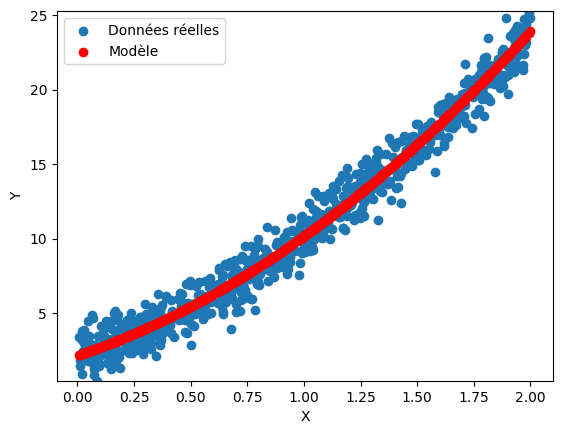

In [50]:
draw_linear_regression_models(train,F_train,name_feature,name_target)

In [51]:
train[[name_target,'Prediction']]

,Y,Prediction
0,2.566032,3.391035
1,4.571691,4.337510
2,19.041801,18.127618
3,11.534779,11.850440
4,4.715003,3.822416
...,...,...
795,6.965455,5.277740
796,5.447022,5.965423
797,8.393845,8.037301
798,3.953697,3.293322


Partie Test

Ici, on utilise les données de test, donc on n'entraîne plus le modèle ; on utilise simplement les coefficients calculés (notre nouvelle matrice THETA).

In [52]:
THETA_test = load_theta_selected(THETA_FOR_TEST=coefficients['θ'].iloc[0],n=n) #On récupère la matrice THETA qui a été stocké dans un fichier csv.

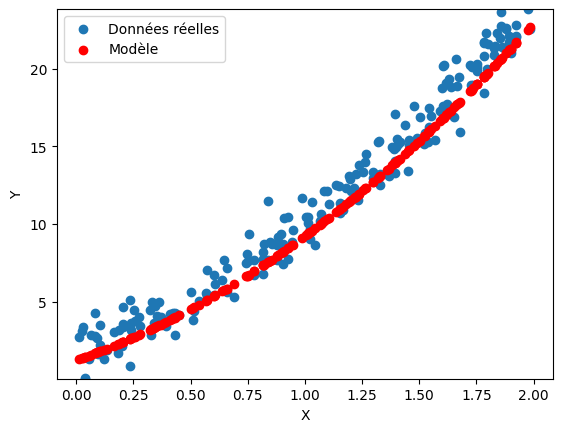

In [53]:
m_test = test.shape[0] #Nombre de lignes, pour les variables
X_test = matrix_X(data=test, name_feature=name_feature, n=n)
Y_test = matrix_Y(data=test, name_target=name_target, m=m_test)
F_test = matrix_F(X=X_test, THETA=THETA_test)
draw_linear_regression_models(test,F_test,name_feature,name_target)

In [54]:
info_metrics_test = metrics(X=X_test,Y=Y_test,F=F_test,m=m_test)

In [55]:
info_metrics_test 

MSE     34445.842761
RMSE      185.595913
R2          0.960498
dtype: float64

In [56]:
test #Les prédictions sur les données de test.

,X,Y,Prediction
0,0.820794,8.690585,7.369510
1,0.753889,9.328582,6.725593
2,1.782286,20.815120,19.453032
3,1.072193,10.657286,10.018077
4,1.136617,12.483416,10.755037
...,...,...,...
195,1.319968,15.266905,12.982424
196,1.231700,11.563412,11.886108
197,1.221240,13.228763,11.759145
198,1.829692,21.490528,20.185673
